In [1]:
import os
import sys 
os.chdir('..')
sys.path.insert(0, os.getcwd())
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from AE_pipeline_pytorch import (
    LSTMAutoencoder,
    BiLSTMAutoencoder,
    GaitAutoencoder,
    
    GaitBatchIterable,

    train_autoencoder,
    evaluate_and_detect,
    extract_and_save_latents,
    reconstruct_and_evaluate,
    evaluate_autoencoder,
    evaluate_autoencoder_streaming,

    
)

from torch.optim import AdamW
from sklearn.metrics import r2_score



import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
      accuracy_score, classification_report,
      adjusted_rand_score, normalized_mutual_info_score
)



2025-07-07 18:33:50.246719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751924030.262915  638381 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751924030.267627  638381 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751924030.280916  638381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751924030.280934  638381 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751924030.280936  638381 computation_placer.cc:177] computation placer alr

Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#Data loader for Zarr datasets
batch_size = 256
train_loader = DataLoader(GaitBatchIterable("train_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)


val_loader = DataLoader(GaitBatchIterable("val_cycles.zarr",batch_size=batch_size, return_meta=False),
    batch_size=None,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

test_loader = DataLoader(
    GaitBatchIterable("test_cycles.zarr", batch_size=batch_size, return_meta=True), 
    batch_size=None, 
    num_workers=4,   
    shuffle=False,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)



In [4]:
#Load the model LSTM autoencoder
model = LSTMAutoencoder(
        n_timesteps=100,
        n_vars=321,
        latent_dim=64,
        dropout=0.2
    )
model_path = "saved_models/ae_lstm_Torch6_64la_tanh_30ep_ini_l2.pth"

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

LSTMAutoencoder(
  (encoder): LSTM(321, 64, batch_first=True)
  (decoder): LSTM(64, 64, batch_first=True)
  (hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=64, out_features=321, bias=True)
)

In [21]:
#Load the model convolutional autoencoder
model = GaitAutoencoder(input_channels=321, seq_length=100, latent_dim=20)
model_path = "best_gait_autoencoder.pt"
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

GaitAutoencoder(
  (encoder_conv): Sequential(
    (0): Conv1d(321, 16, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder_fc): Linear(in_features=800, out_features=20, bias=True)
  (decoder_fc): Linear(in_features=20, out_features=800, bias=True)
  (decoder_conv): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(32, 25))
    (1): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (2): ReLU(inplace=True)
    (3): ConvTranspose1d(16, 321, kernel_size=(3,), stride=(2,), padding=(1,), output_padding=(1,))
    (4): Sigmoid()
  )
)

# Evaluation and reconstruction 

In [6]:
metrics = evaluate_autoencoder_streaming(model, test_loader, device)
print(f"MSE (streaming): {metrics['mse']:.6f}")
print(f"MAE (streaming): {metrics['mae']:.6f}")

MSE (streaming): 0.953883
MAE (streaming): 0.693098


In [ ]:
# Reconstruct and evaluate on a subset of cycles for specific variables (CONV MODEL)
selected_vars = [313, 314, 315]
MAX_CYCLES  = 200
BATCH_SIZE  = 16
epsilon       = 1e-8

# ─── 1. Muestreo por reservoir (sin acumular todo) ────────────────
reservoir = []   # aquí guardaremos up to MAX_CYCLES ciclos (tensors CPU)
n_seen = 0

with torch.no_grad():
    for batch in test_loader:
        # extrae sólo los datos (batch puede ser (x,meta))
        x_batch = batch[0] if isinstance(batch, (list,tuple)) else batch
        # movemos a CPU para no saturar GPU
        x_cpu = x_batch.cpu()
        for cycle in x_cpu:
            n_seen += 1
            if len(reservoir) < MAX_CYCLES:
                reservoir.append(cycle)
            else:
                j = np.random.randint(0, n_seen)
                if j < MAX_CYCLES:
                    reservoir[j] = cycle

# Si no llenamos el reservoir (dataset pequeño), lo respetamos
M = len(reservoir)
print(f"Reservoir sampling: {M} ciclos almacenados (de {n_seen} vistos).")

# ─── 2. Creamos un DataLoader sólo para esos ciclos ───────────────
sample_cycles = torch.stack(reservoir)        # [M, C, T]
sample_loader = DataLoader(
    sample_cycles,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# ─── 3. Reconstrucción y cálculo de métricas sólo sobre selected_vars ──
sum_mse, sum_mae, sum_mape = 0.0, 0.0, 0.0
count = 0

model.eval()
with torch.no_grad():
    for batch_x in sample_loader:
        batch_x = batch_x.to(device)           # [B, C, T]
        recon, _ = model(batch_x)              # [B, C, T]

        # permutamos a [B, T, C] para indexar variables
        x_orig = batch_x.permute(0,2,1)[..., selected_vars]
        x_rec  = recon     .permute(0,2,1)[..., selected_vars]

        err = x_orig - x_rec
        mse_b  = err.pow(2).mean(dim=(1,2)).cpu().numpy()
        mae_b  = err.abs().mean(dim=(1,2)).cpu().numpy()
        mape_b = (err.abs()/(x_orig.abs()+epsilon)).mean(dim=(1,2)).cpu().numpy()*100

        sum_mse  += mse_b.sum()
        sum_mae  += mae_b.sum()
        sum_mape += mape_b.sum()
        count   += mse_b.shape[0]

mse_global  = sum_mse  / count
mae_global  = sum_mae  / count
mape_global = sum_mape / count

print(f"\nEvaluación sobre {count} ciclos muestreados:")
print(f"  MSE:  {mse_global:.6f}")
print(f"  MAE:  {mae_global:.6f}")
print(f"  MAPE: {mape_global:.2f}%")

Reservoir sampling: 200 ciclos almacenados (de 35328 vistos).

Evaluación sobre 200 ciclos muestreados:
  MSE:  1.002850
  MAE:  0.770970
  MAPE: 233.62%


In [8]:
# Reconstruct and evaluate on a subset of cycles for specific variables (LSTM MODEL)
import torch
import numpy as np
from torch.utils.data import DataLoader

# Parámetros
selected_vars = [313, 314, 315]
MAX_CYCLES    = 200
BATCH_SIZE    = 16
epsilon       = 1e-8
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. Muestreo por reservoir (sin acumular todo) ────────────────
reservoir = []   # Up to MAX_CYCLES ciclos (cada uno es [C, T] en CPU)
n_seen = 0

with torch.no_grad():
    for batch in test_loader:  # el iterable que devuelve (x, meta)
        x_batch = batch[0] if isinstance(batch, (list,tuple)) else batch
        x_cpu   = x_batch.cpu()  # [B, C, T]
        for cycle in x_cpu:      # cycle: [C, T]
            n_seen += 1
            if len(reservoir) < MAX_CYCLES:
                reservoir.append(cycle)
            else:
                j = np.random.randint(0, n_seen)
                if j < MAX_CYCLES:
                    reservoir[j] = cycle

M = len(reservoir)
print(f"Reservoir sampling: {M} ciclos almacenados (de {n_seen} vistos).")

# ─── 2. DataLoader para los ciclos muestreados ────────────────────
# Cada ciclo tiene forma [C, T], apilamos a [M, C, T]
sample_cycles = torch.stack(reservoir)
sample_loader = DataLoader(
    sample_cycles,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# ─── 3. Reconstrucción + cálculo de métricas ─────────────────────
sum_mse, sum_mae, sum_mape = 0.0, 0.0, 0.0
count = 0

model.eval()
with torch.no_grad():
    for batch_x in sample_loader:
        # batch_x: [B, C, T] → permutar para LSTM: [B, T, C]
        x = batch_x.permute(0, 2, 1).to(device)  # [B, T, V]

        # encode + decode
        z     = model.encode(x)                  # [B, latent_dim]
        recon = model.decode(z)                  # [B, T, V]

        # seleccionamos solo las variables de interés
        x_orig = x   [..., selected_vars]        # [B, T, len(selected_vars)]
        x_rec  = recon[..., selected_vars]       # [B, T, len(selected_vars)]

        # errores por ciclo
        err    = x_orig - x_rec
        mse_b  = err.pow(2).mean(dim=(1,2)).cpu().numpy()         # (B,)
        mae_b  = err.abs() .mean(dim=(1,2)).cpu().numpy()         # (B,)
        mape_b = (err.abs()/(x_orig.abs()+epsilon)) \
                      .mean(dim=(1,2)).cpu().numpy() * 100        # (B,)

        sum_mse  += mse_b.sum()
        sum_mae  += mae_b.sum()
        sum_mape += mape_b.sum()
        count   += mse_b.shape[0]

# ─── 4. Métricas globales ────────────────────────────────────────
mse_global  = sum_mse  / count
mae_global  = sum_mae  / count
mape_global = sum_mape / count

print(f"\nEvaluación LSTM-AE sobre {count} ciclos muestreados:")
print(f"  MSE:  {mse_global:.6f}")
print(f"  MAE:  {mae_global:.6f}")
print(f"  MAPE: {mape_global:.2f}%")


Reservoir sampling: 200 ciclos almacenados (de 35328 vistos).

Evaluación LSTM-AE sobre 200 ciclos muestreados:
  MSE:  0.297309
  MAE:  0.419738
  MAPE: 1172.36%


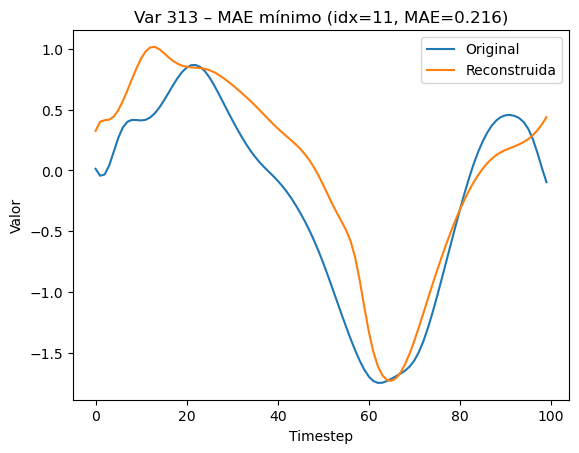

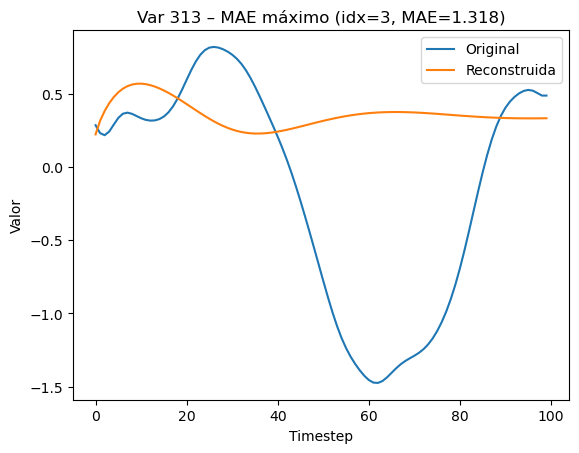

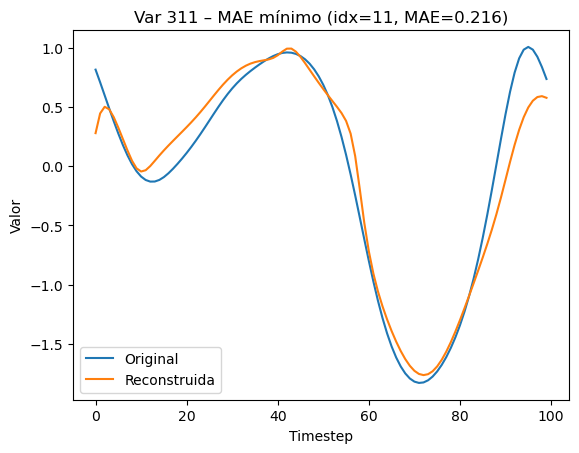

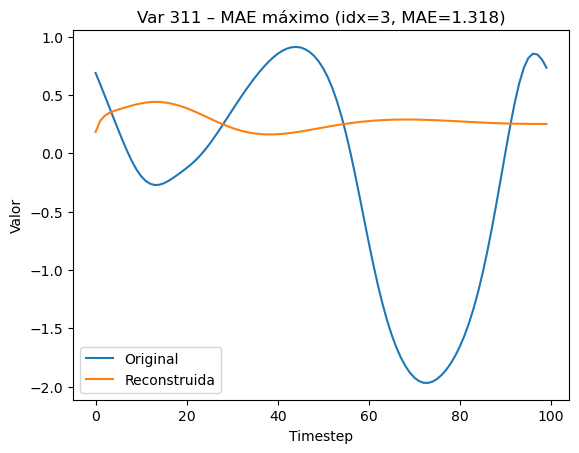

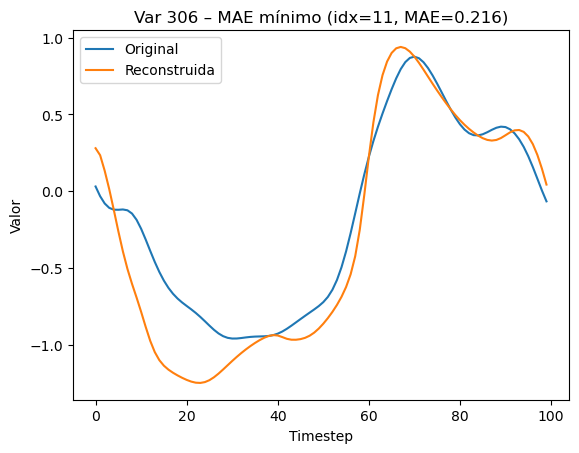

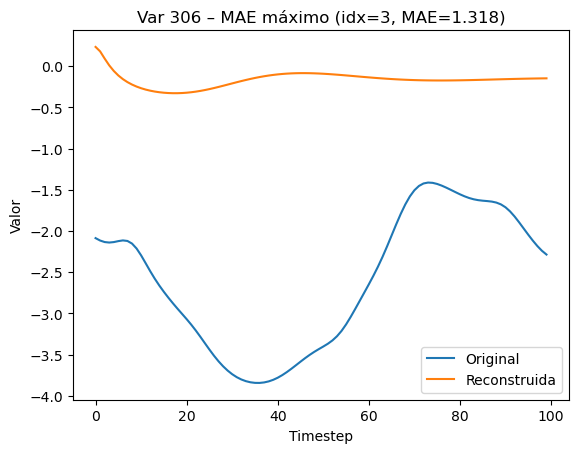

In [10]:
# To plot the reconstructions of the sampled cycles (LSTM MODEL)


# ─── Parámetros ────────────────────────────────────────────────
selected_vars = [313, 311, 306]
BATCH_SIZE    = 16
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. DataLoader sobre sample_cycles (CPU) ────────────────────
# sample_cycles debe ser el tensor [M, C, T] obtenido con reservoir sampling
plot_loader = DataLoader(sample_cycles, batch_size=BATCH_SIZE, shuffle=False)

# ─── 2. Recorrer para recolectar originales, reconstrucciones y MAE ─
orig_list, recon_list, mae_list = [], [], []

model.eval()
with torch.no_grad():
    for batch_x in plot_loader:
        # batch_x: [B, C, T]
        batch_x = batch_x.to(device)

        # 1) Permutar para LSTM: [B, C, T] → [B, T, C]
        x = batch_x.permute(0, 2, 1)  # [B, T, V]

        # 2) Bottleneck + reconstrucción
        z     = model.encode(x)       # [B, latent_dim]
        recon = model.decode(z)       # [B, T, V]

        # 3) Seleccionar variables de interés (ya en [B, T, V])
        x_orig = x   [..., selected_vars].cpu().numpy()  # (B, T, 3)
        x_rec  = recon[..., selected_vars].cpu().numpy()  # (B, T, 3)

        # 4) Calcular MAE por ciclo
        err      = np.abs(x_orig - x_rec)                # (B, T, 3)
        mae_batch = err.mean(axis=(1,2))                 # (B,)

        orig_list.append(x_orig)
        recon_list.append(x_rec)
        mae_list.append(mae_batch)

# ─── 3. Concatenar todos los lotes ───────────────────────────────
orig_cycles  = np.concatenate(orig_list,  axis=0)  # (M, T, 3)
recon_cycles = np.concatenate(recon_list, axis=0)
mae_cycles   = np.concatenate(mae_list,  axis=0)  # (M,)

# ─── 4. Índices de mejor y peor reconstrucción ───────────────────
idx_min = np.argmin(mae_cycles)
idx_max = np.argmax(mae_cycles)
T = orig_cycles.shape[1]

# ─── 5. Graficar para cada variable ─────────────────────────────
for i, var in enumerate(selected_vars):
    # Mejor reconstrucción
    plt.figure()
    plt.plot(np.arange(T), orig_cycles[idx_min,:,i],  label="Original")
    plt.plot(np.arange(T), recon_cycles[idx_min,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE mínimo (idx={idx_min}, MAE={mae_cycles[idx_min]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    plt.close()

    # Peor reconstrucción
    plt.figure()
    plt.plot(np.arange(T), orig_cycles[idx_max,:,i],  label="Original")
    plt.plot(np.arange(T), recon_cycles[idx_max,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE máximo (idx={idx_max}, MAE={mae_cycles[idx_max]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()
    plt.close()


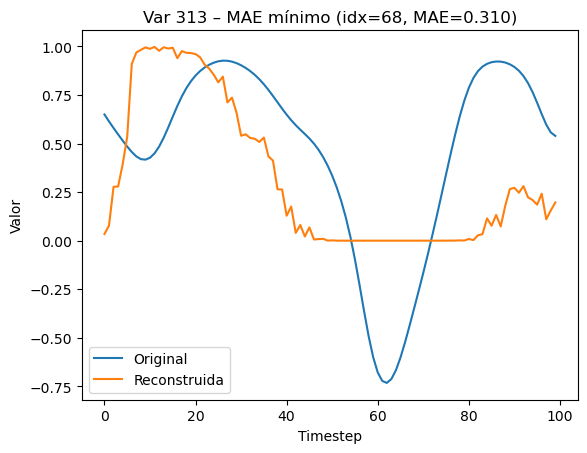

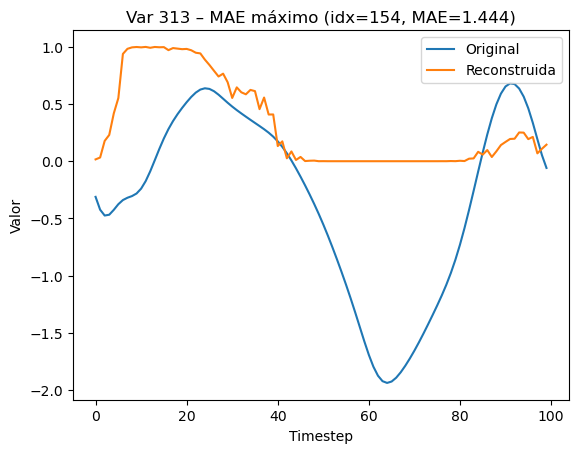

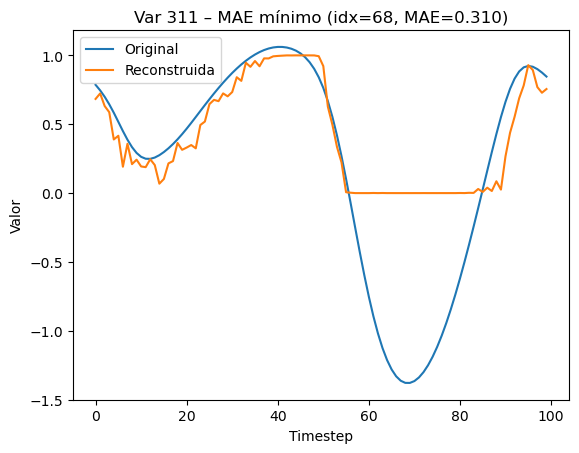

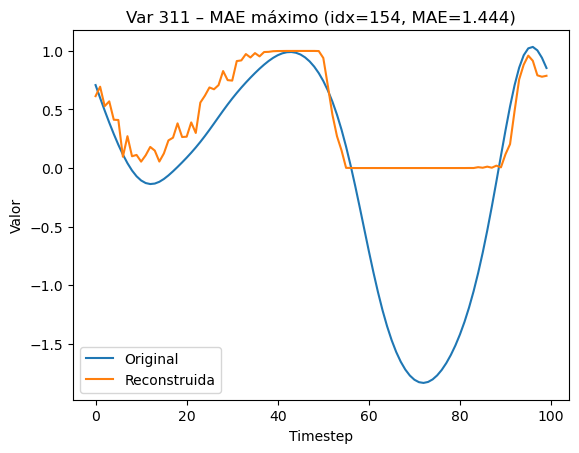

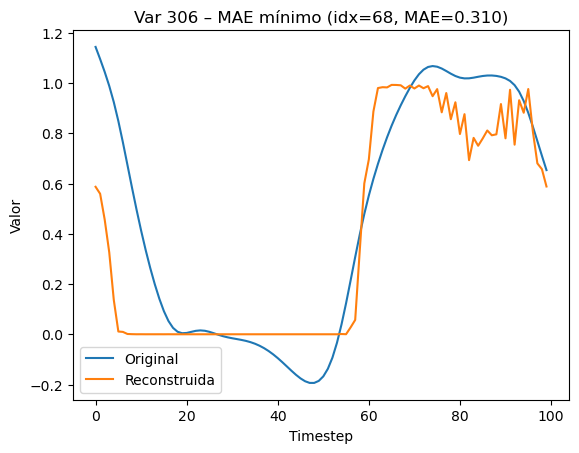

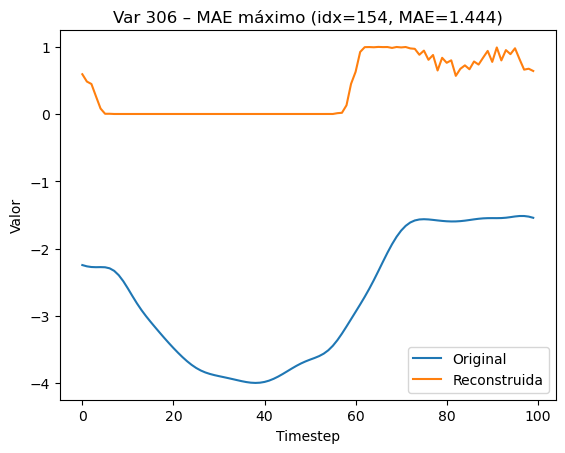

In [ ]:
#To plot the reconstructions of the sampled cycles (MODEL CONVOLUTIONAL)
# ─── Parámetros ────────────────────────────────────────────────
selected_vars = [313, 311, 306]
BATCH_SIZE    = 16
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 1. DataLoader sobre los ciclos muestreados ───────────────
# sample_cycles: Tensor CPU [M, C, T]
plot_loader = DataLoader(sample_cycles, batch_size=BATCH_SIZE, shuffle=False)

# ─── 2. Recorrer para recolectar originales, reconstrucciones y MAE ─
orig_list  = []
recon_list = []
mae_list   = []

model.eval()
with torch.no_grad():
    for batch_x in plot_loader:
        batch_x = batch_x.to(device)                    # [B, C, T]
        recon, _ = model(batch_x)                       # [B, C, T], y latente

        # Permutamos a [B, T, C] para indexar las variables
        x_orig = batch_x.permute(0,2,1)[..., selected_vars].cpu().numpy()   # (B, T, 3)
        x_rec  = recon     .permute(0,2,1)[..., selected_vars].cpu().numpy()

        err       = np.abs(x_orig - x_rec)               # (B, T, 3)
        mae_batch = err.mean(axis=(1,2))                 # (B,)

        orig_list.append(x_orig)
        recon_list.append(x_rec)
        mae_list.append(mae_batch)

# ─── 3. Concatenar todos los lotes ────────────────────────────
orig_cycles  = np.concatenate(orig_list,  axis=0)  # (M, T, 3)
recon_cycles = np.concatenate(recon_list, axis=0)
mae_cycles   = np.concatenate(mae_list,  axis=0)  # (M,)

# ─── 4. Índices de mejor y peor reconstrucción ────────────────
idx_min = np.argmin(mae_cycles)
idx_max = np.argmax(mae_cycles)
T = orig_cycles.shape[1]

# ─── 5. Graficar para cada variable ───────────────────────────
for i, var in enumerate(selected_vars):
    # Mejor reconstrucción
    plt.figure()
    plt.plot(range(T), orig_cycles[idx_min,:,i],  label="Original")
    plt.plot(range(T), recon_cycles[idx_min,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE mínimo (idx={idx_min}, MAE={mae_cycles[idx_min]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

    # Peor reconstrucción
    plt.figure()
    plt.plot(range(T), orig_cycles[idx_max,:,i],  label="Original")
    plt.plot(range(T), recon_cycles[idx_max,:,i], label="Reconstruida")
    plt.title(f"Var {var} – MAE máximo (idx={idx_max}, MAE={mae_cycles[idx_max]:.3f})")
    plt.xlabel("Timestep")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Clustering 

In [ ]:
# To identify the meta information in the test_loader
for batch in test_loader:
    # Desempaquétalo
    if isinstance(batch, (list, tuple)) and len(batch) > 1:
        x_batch, meta = batch
    else:
        meta = batch

    # Muestra tipo y contenido bruto
    print("Tipo de meta:", type(meta))
    print("Contenido de meta:", meta)
    
    # Si fuera un diccionario, muestra sus llaves
    if isinstance(meta, dict):
        print("Keys en meta:", meta.keys())
        # y un ejemplo de cada campo
        for k, v in meta.items():
            print(f"  {k} -> {v[:5]}{'...' if len(v)>5 else ''}")
    # Si fuera una lista de tuplas u otro, haz un print más específico
    else:
        print("Primer elemento de meta:", meta[0])
    
    break  # con esto solo imprimimos el primer batch


Tipo de meta: <class 'torch.Tensor'>
Contenido de meta: tensor([[[2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [3., 3., 3.,  ..., 3., 3., 3.]],

        ...,

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[2., 2., 2.,  ..., 2., 2., 2.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [2., 2., 2.

Clustering accuracy: 0.530


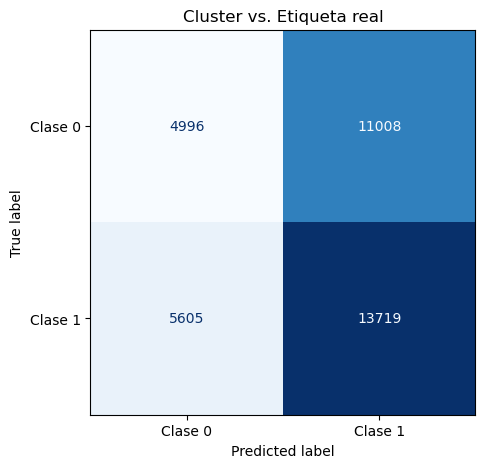

               precision    recall  f1-score   support

Clase 0 (G01)       0.47      0.31      0.38     16004
Clase 1 (G03)       0.55      0.71      0.62     19324

     accuracy                           0.53     35328
    macro avg       0.51      0.51      0.50     35328
 weighted avg       0.52      0.53      0.51     35328

Adjusted Rand Index:          0.0021076387168098786
Normalized Mutual Info Score: 0.00044358826744479095


In [5]:
# ─── Clustering de latentes (LSTM-AE) ───────────────────────────


# Parámetros
N_CLUSTERS, RANDOM_STATE = 2, 0

latents_list, true_labels_list = [], []
model.eval()

with torch.no_grad():
    for batch in test_loader:  
        # 1) Extraer datos y meta
        x_batch, meta = batch  # asumiendo return_meta=True
        # x_batch: [B, C, T], meta: [B,5,T]
        
        # 2) Permutar y mover a device
        x = x_batch.permute(0, 2, 1).to(device)  # [B, T, C]
        
        # 3) Extraer latente con encode
        z = model.encode(x)                      # [B, latent_dim]
        latents_list.append(z.cpu().numpy())
        
        # 4) Extraer etiqueta de grupo (fila 1 es G01/G03)
        grp = (meta[:, 1, 0] == 3).long().cpu().numpy()  # 0=G01, 1=G03
        true_labels_list.append(grp)

# Concatenar
latents     = np.concatenate(latents_list,     axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

# Clustering
cluster_labels = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=10
).fit_predict(latents)

# Alinear si hace falta
acc = accuracy_score(true_labels, cluster_labels)
if acc < .5:
    cluster_labels = 1 - cluster_labels
    acc = 1 - acc
print(f"Clustering accuracy: {acc:.3f}")

# Matriz de confusión
cm = confusion_matrix(true_labels, cluster_labels)
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", ax=ax, values_format="d", colorbar=False)

ticks = np.arange(N_CLUSTERS)
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_xticklabels([f"Clase {i}" for i in ticks])
ax.set_yticklabels([f"Clase {i}" for i in ticks])
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_title("Cluster vs. Etiqueta real")
plt.show()

# Reporte detallado
print(classification_report(
    true_labels, cluster_labels,
    labels=[0,1],
    target_names=["Clase 0 (G01)", "Clase 1 (G03)"]
))

# ARI y NMI
print("Adjusted Rand Index:         ", adjusted_rand_score(true_labels, cluster_labels))
print("Normalized Mutual Info Score:", normalized_mutual_info_score(true_labels, cluster_labels))


In [ ]:
# ─── Clustering de latentes model convolutional ────────────────────────────────────

# Parámetros de clustering
N_CLUSTERS   = 2
RANDOM_STATE = 0

# ─── 2. Extraer latentes y etiquetas verdaderas ──────────────────
latents_list, true_labels_list = [], []
model.eval()
with torch.no_grad():
    for x_batch, meta in test_loader:
        # x_batch: [B, C, T]
        x = x_batch.to(device)
        _, z = model(x)  # (recon, z)
        latents_list.append(z.cpu().numpy())

        # extraer grupo de meta[:,1,0]: G01→1, G03→3 → binario 0/1
        grp = (meta[:, 1, 0] == 3).long().cpu().numpy()
        true_labels_list.append(grp)

# concatenar todo
latents     = np.concatenate(latents_list,     axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

# ─── 3. Clustering con KMeans ────────────────────────────────────
cluster_labels = KMeans(
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    n_init=10
).fit_predict(latents)

# ─── 4. Alinear etiquetas si la exactitud es < 50% ──────────────
print("true_labels dtype:", true_labels.dtype, "uniques:", np.unique(true_labels))
print("cluster_labels dtype:", cluster_labels.dtype, "uniques:", np.unique(cluster_labels))

acc = accuracy_score(true_labels, cluster_labels)
if acc < 0.5:
    cluster_labels = 1 - cluster_labels
    acc = 1 - acc
print(f"Clustering accuracy: {acc:.3f}")

# ─── 5. Matriz de confusión ──────────────────────────────────────
cm = confusion_matrix(true_labels, cluster_labels)
disp = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap="Blues", ax=ax, values_format="d", colorbar=False)

# forzamos solo dos ticks (0 y 1)
ticks = np.arange(N_CLUSTERS)  # array([0,1])
ax.set_xticks(ticks)
ax.set_yticks(ticks)

# asignamos las dos etiquetas
labels = [f"Clase {i}" for i in range(N_CLUSTERS)]
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Cluster vs. Etiqueta real")
plt.show()

# ─── 6. Reporte detallado ────────────────────────────────────────
print(classification_report(
    true_labels,
    cluster_labels,
    labels=[0,1],  # especificamos ambas clases
    target_names=["Clase 0 (G01)", "Clase 1 (G03)"]
))

# ─── 7. Índices de Rand y Mutual Info ────────────────────────────
ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index:          {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

RuntimeError: DataLoader worker (pid(s) 636757, 636758, 636759, 636760) exited unexpectedly